# Number of neighbors sensitivity analysis for TISSUE cell-centric variability

This notebook tests the sensitivity of TISSUE cell-centric variability estimates to the number of neighbors chose to compute the metric.

The notebook requires having the dataset folders formatted and in "DataUpload" top-level directory in the current working directory. The data can be retrieved from the Zenodo repository in our manuscript (DOI: 10.5281/zenodo.8259942).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import scanpy as sc
import squidpy as sq
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from scipy.spatial.distance import cosine
import anndata as ad
import warnings
import time
import pickle
import os

from decimal import Decimal

from TISSUE.tissue.main import *

In [2]:
dataset_mapper = {"Dataset3": "Mouse Hipp. (seqFISH)",
                  "Dataset9": "Mouse VISP (MERFISH)",
                  "Dataset11": "Mouse PC (STARmap)", 
                  "Dataset12": "Human MTG (ISS)",
                  "Dataset13": "Mouse VISP (ISS)",
                  "Dataset14": "Drosophila Embryo (FISH)",
                  "Dataset15": "Mouse SC (osmFISH)",
                  "Dataset17": "Mouse VISP (ExSeq)",
                  "Axolotl": "Axolotl Brain (Stereo-seq)",
                  "Dataset7": "Human U2OS (MERFISH)",
                  "Dataset1": "Mouse Gast. (seqFISH)"}

method_mapper = {"spage": "SpaGE",
                 "knn": "Harmony",
                 "tangram": "Tangram"}

## Generate results for different number of neighbors

In [5]:
num_neighbors = [5,10,15,20,25,30] # number of neighbors to test

datasets = ["Dataset3", "Dataset11", "Dataset14", "Dataset15",
            "Dataset1", "Dataset7"] # other datasets run into out-of-memory error when allocating sensitivity results

In [6]:
n_folds = 10 # folds for prediction
k_gene = 'auto' # using automatic stratified grouping
k_cell = 'auto' # using automatic stratified grouping
method = "tangram" # change to "knn" and "harmony" to generate additional results for other prediction models

#--------------------------------------------------------------
for dataset_name in datasets:
    
    # read data
    if os.path.isfile("DataUpload/"+dataset_name+"/Metadata.txt"):
        adata, RNAseq_adata = load_paired_datasets("DataUpload/"+dataset_name+"/Spatial_count.txt",
                                                    "DataUpload/"+dataset_name+"/Locations.txt",
                                                    "DataUpload/"+dataset_name+"/scRNA_count.txt",
                                                    spatial_metadata = "DataUpload/"+dataset_name+"/Metadata.txt")
    else:
        adata, RNAseq_adata = load_paired_datasets("DataUpload/"+dataset_name+"/Spatial_count.txt",
                                                    "DataUpload/"+dataset_name+"/Locations.txt",
                                                    "DataUpload/"+dataset_name+"/scRNA_count.txt")
    adata.var_names = [x.lower() for x in adata.var_names]
    RNAseq_adata.var_names = [x.lower() for x in RNAseq_adata.var_names]

    # preprocess RNAseq data
    preprocess_data(RNAseq_adata, standardize=False, normalize=True)

    # subset spatial data into shared genes
    gene_names = np.intersect1d(adata.var_names, RNAseq_adata.var_names)
    adata = adata[:, gene_names]
    
    # prediction
    target_genes = [adata.var_names[1]]
    predicted = method+"_predicted_expression"
    if method == "spage":
        if len(adata.var_names) < 40:
            n_pv = 20
        else:
            n_pv = round(np.min([len(adata.var_names), len(adata.obs_names)])/2)

        predict_gene_expression (adata, RNAseq_adata, target_genes,
                                 method=method, n_folds=n_folds, n_pv=n_pv)
    elif method == "knn":
        predict_gene_expression (adata, RNAseq_adata, target_genes,
                                 method=method, n_folds=n_folds, n_neighbors=10)
    else:
        predict_gene_expression (adata, RNAseq_adata, target_genes,
                                 method=method, n_folds=n_folds)
    
    # NUM NEIGHBORS ANALYSIS
    for nneigh in num_neighbors:
        print(nneigh)
        build_spatial_graph(adata, method="fixed_radius", n_neighbors=nneigh)
    
        # compute CCV
        calib_genes = [adata.var_names[0]] # just filler since only care about CCV
        conformalize_spatial_uncertainty(adata, predicted, calib_genes, weight="exp_cos", mean_normalized=False, add_one=True,
                                         grouping_method="kmeans_gene_cell", k=k_gene, k2=k_cell, n_pc=15)
    
        # append CCV
        scores, residuals, G_stdev, G, groups = get_spatial_uncertainty_scores_from_metadata (adata, predicted)
        
        np.save(f"num_neigh_results/{dataset_name}_{method}_{nneigh}.npy", G_stdev)
        
    print(f"Done with {dataset_name}")

/home/edsun/.conda/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/edsun/.conda/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:872: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  names = self._prep_dim_index(names, "obs")
/home/edsun/.conda/envs/geneimputation/lib/python3.8/site-packages/anndata/_core/anndata.py:896: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  self._set_dim_index(names, "var")
/oak/stanford/scg/lab_abrunet1/Eric/GeneImputation/TISSUE/tissue/main.py:239: UserWarning: Some target_genes are alr

Found 1 duplicate conf_gene in target_genes.


INFO:root:265 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:265 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 265 genes and rna_count_based density_prior in clusters mode...
INFO:root:Saving results..
INFO:root:265 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:265 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in 

5
10
15
20
25
30
Done with Dataset1


INFO:root:7251 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:7251 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 7251 genes and rna_count_based density_prior in clusters mode...
INFO:root:Saving results..


Found 1 duplicate conf_gene in target_genes.


INFO:root:6526 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:6526 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 6526 genes and rna_count_based density_prior in clusters mode...
INFO:root:Saving results..
INFO:root:6526 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:6526 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and save

5
10
15
20
25
30
Done with Dataset7


## Analyze and plot results for different numbers of neighbors

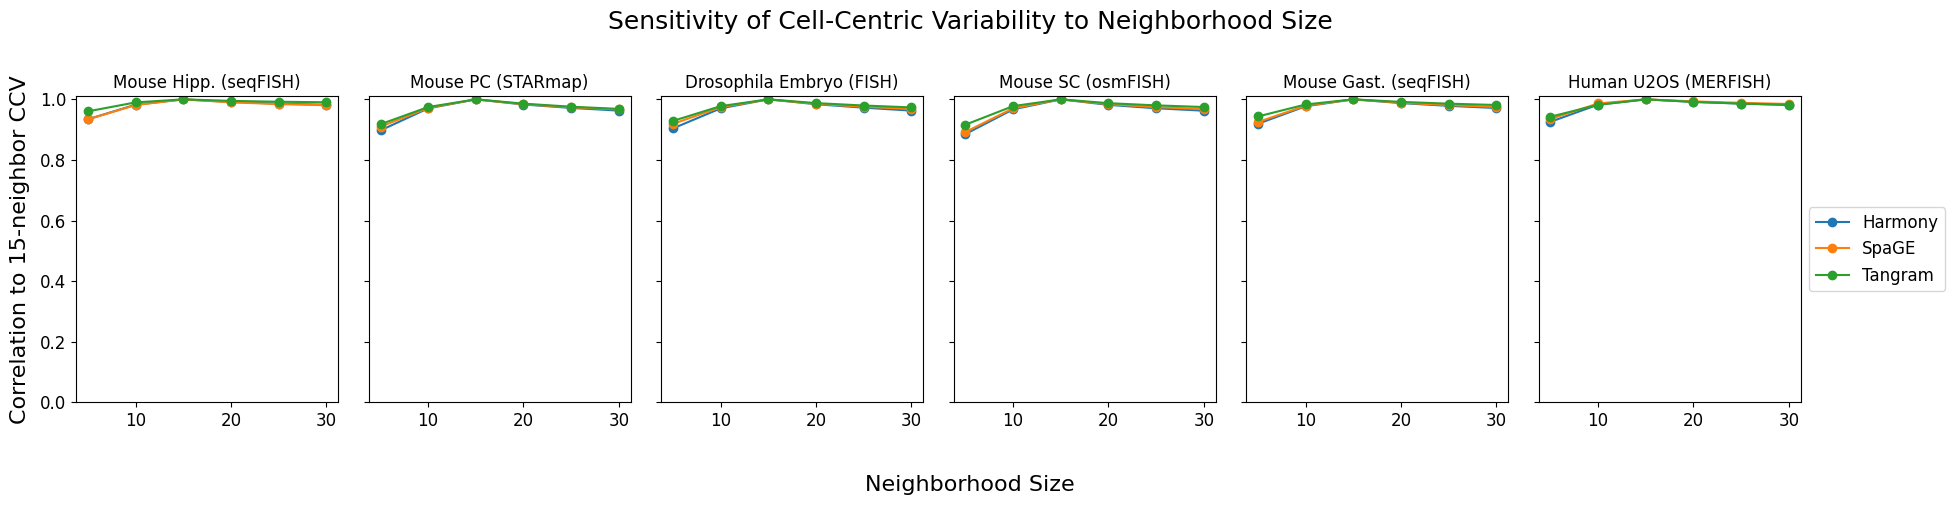

In [4]:
datasets = ["Dataset3", "Dataset11", "Dataset14", "Dataset15",
            "Dataset1", "Dataset7"]
methods = ["knn", "spage", "tangram"]
num_neighbors = [5,10,15,20,25,30]

#-------------------------------------------------------------------
fig, axs = plt.subplots(1, len(datasets), sharey=True, figsize=(20, 5))

# make subplot for each dataset where each line is the correlation to num_neigh=15 CCV for a given prediction model
for di, dataset_name in enumerate(datasets):
    
    for method in methods:
        
        # read in CCV values
        G_stdev = np.load(f"num_neigh_results/{dataset_name}_{method}_15.npy")
        init_G_stdev = G_stdev.copy().flatten()
        
        # get correlation to num_neigh=15
        correlations = []
        for nneigh in num_neighbors:
            G_stdev = np.load(f"num_neigh_results/{dataset_name}_{method}_{nneigh}.npy")
            correlations.append(pearsonr(G_stdev.flatten(),init_G_stdev)[0])
            
        axs[di].plot(num_neighbors,correlations,"o-",label=method_mapper[method])
    
    axs[di].set_title(f"{dataset_mapper[dataset_name]}")
    axs[di].set_ylim(0,1.01)
    axs[di].tick_params(axis='both', which='major', labelsize=12)
    axs[di].tick_params(axis='both', which='minor', labelsize=12)
    
fig.suptitle("Sensitivity of Cell-Centric Variability to Neighborhood Size", fontsize=18)
fig.supxlabel("Neighborhood Size", fontsize=16)
fig.supylabel("Correlation to 15-neighbor CCV", fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1)
plt.tight_layout(pad=1.8)
plt.savefig('plots/neighborhood_size_ccv_correlation_to15.pdf')
plt.show()